# Import

In [26]:
from dataclasses import dataclass
from typing import Any, Union, Tuple, Callable, Optional
from functools import partial
import time

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax

from qdax import environments, environments_v1

import pickle

from IPython.display import HTML
from brax.io import html
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Environment

In [20]:
seed = 42

# Init a random key
random_key = jax.random.PRNGKey(seed)
random_key, random_subkey = jax.random.split(random_key)

# Init env
env_name = "ant_uni"

if env_name == "hopper_uni":
	episode_length = 1000
	max_bd = 1.

	env = environments.create(env_name, episode_length=episode_length)
elif env_name == "halfcheetah_uni":
	episode_length = 1000
	max_bd = 1.

	env = environments.create(env_name, episode_length=episode_length)
elif env_name == "walker2d_uni":
	episode_length = 1000
	max_bd = 1.

	env = environments.create(env_name, episode_length=episode_length)	
elif env_name == "ant_uni":
	episode_length = 1000
	max_bd = 1.

	env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)
elif env_name == "ant_omni":
	episode_length = 250
	max_bd = 30.

	env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)	
elif env_name == "humanoid_uni":
	episode_length = 1000
	max_bd = 1.

	env = environments.create(env_name, episode_length=episode_length)	
else:
	ValueError(f"Environment {env_name} not supported.")

# Policy

## Agent

In [27]:
def get_env(env_name):
    if env_name == "hopper_uni":
        episode_length = 1000
        
        env = environments_v1.create(env_name, episode_length=episode_length)
    elif env_name == "halfcheetah_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)
        
    elif env_name == "walker2d_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length)	
    elif env_name == "ant_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=True)
    elif env_name == "humanoid_uni":
        episode_length = 1000

        env = environments_v1.create(env_name, episode_length=episode_length, exclude_current_positions_from_observation=True)	
    '''
    elif env_name == "ant_omni":
        episode_length = 250
        max_bd = 30.

        env = environments.create(env_name, episode_length=episode_length, use_contact_forces=False, exclude_current_positions_from_observation=False)	
    elif env_name == "humanoid_uni":
        episode_length = 1000
        max_bd = 1.

        env = environments.create(env_name, episode_length=episode_length)	
    else:
        ValueError(f"Environment {env_name} not supported.")
    '''
    return env

In [ ]:
EPS = 1e-8
class Normalizer:
    def __init__(self, size, epsilon=1e-8):
        self.size = size
        self.mean = jnp.zeros(size)
        self.var = jnp.ones(size)
        self.count = epsilon

    def update(self, x):
        batch_mean = jnp.mean(x, axis=0)
        batch_var = jnp.var(x, axis=0)
        batch_count = x.shape[0]

        self.mean, self.var, self.count = self._update_mean_var_count(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)

    def normalize(self, x):
        return (x - self.mean) / jnp.sqrt(self.var + EPS)

    def _update_mean_var_count(self, mean, var, count, batch_mean, batch_var, batch_count):
        delta = batch_mean - mean
        tot_count = count + batch_count

        new_mean = mean + delta * batch_count / tot_count
        m_a = var * count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        return new_mean, new_var, new_count

In [28]:
_half_log2pi = 0.5 * jnp.log(2 * jnp.pi)
EPS = 1e-8

class MLP(nn.Module):
	"""Descriptor-conditioned MLP module."""
	hidden_layers_size: Tuple[int, ...]
	action_size: int
	activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh
 
	def setup(self):
		self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2)), bias_init=jax.nn.initializers.zeros) for hidden_layer_size in self.hidden_layers_size]
		self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01), bias_init=jax.nn.initializers.zeros)
		self.log_std = self.param("log_std", lambda _, shape: jnp.log(0.5)*jnp.ones(shape), (self.action_size,))
 
	'''
	def setup(self):
		if env_name == "walker2d_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size)
			self.log_std = self.param("log_std", lambda _, shape: -0.5*jnp.ones(shape), (self.action_size,))
		elif env_name == "ant_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2))) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01))
			self.log_std = self.param("log_std", lambda _, shape: -1.*jnp.ones(shape), (self.action_size,))
		elif env_name == "humanoid_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2))) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01))
			self.log_std = self.param("log_std", lambda _, shape: jnp.zeros(shape), (self.action_size,))
		else:
			ValueError(f"Environment {env_name} not supported.")
	'''
	
   
	'''
	def setup(self):
		if env_name == "walker2d_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size)
			self.log_std = self.param("log_std", lambda _, shape: -0.5*jnp.ones(shape), (self.action_size,))
		elif env_name == "ant_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.lecun_uniform(), use_bias=True) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.lecun_uniform(), use_bias=True)
			self.log_std = self.param("log_std", lambda _, shape: -1.*jnp.ones(shape), (self.action_size,))
		elif env_name == "humanoid_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2))) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01))
			self.log_std = self.param("log_std", lambda _, shape: jnp.zeros(shape), (self.action_size,))
		else:
			ValueError(f"Environment {env_name} not supported.")
	'''


	def distribution_params(self, obs: jnp.ndarray):
		hidden = obs
		for hidden_layer in self.hidden_layers:
			hidden = self.activation(hidden_layer(hidden))

		mean = self.mean(hidden)
		log_std = self.log_std
		#std = jnp.exp(log_std)
		std = jax.nn.softplus(log_std)

		return mean, log_std, std

	def logp(self, obs: jnp.ndarray, action: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		mean, log_std, std = self.distribution_params(obs)

		# Log probability
		logp = jnp.sum(-0.5 * jnp.square((action - mean)/(std + EPS)) - _half_log2pi - log_std, axis=-1)

		return logp

	def entropy(self, obs: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		_, _, std = self.distribution_params(obs)

		entropy = self.action_size * (0.5 + _half_log2pi) + 0.5 * jnp.log(jnp.prod(std))
		return entropy

	def __call__(self, random_key, obs: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		mean, log_std, std = self.distribution_params(obs)

		# Sample action
		rnd = jax.random.normal(random_key, shape=(self.action_size,))
		action = jax.lax.stop_gradient(mean + rnd * std)

		# Log probability
		logp = jnp.sum(-0.5 * jnp.square(rnd) - _half_log2pi - log_std, axis=-1)

		return action, logp

# Initialize policy
#policy_hidden_layers_size = [128, 128]
#policy = MLP(hidden_layers_size=policy_hidden_layers_size, action_size=env.action_size, activation=nn.tanh)

## REINFORCE

In [29]:
@dataclass
class Config:
	batch_size: int = 512   # number of trajectories to sample per trainng step
	learning_rate: float = 3e-4  # learning rate for the optimizer
	discount_rate: float = 0.99   # discount factor for future rewards
	temperature: float = 0.    # temperature for entropy regularization
	clip_param: float = 0.2     # clipping parameter for PPO
	max_norm_clip: float = 0.    # maximum norm for gradient clipping


class Reinforce:

	def __init__(self, config, policy, env):
		self._config = config
		self._policy = policy
		self._env = env
		self.normalizer = Normalizer(env.observation_size)

		if env.state_descriptor_name == "feet_contact":
			self.get_desc = self.get_feet_contact_rate
		elif env.state_descriptor_name == "xy_position":
			self.get_desc = self.get_final_xy_position
		else:
			ValueError(f"Descriptor {env.state_descriptor_name} not supported.")

	def init(self, random_key):
		# Initialize params
		random_key_1, random_key_2 = jax.random.split(random_key)
		fake_obs = jnp.zeros(shape=(env.observation_size,))
		params = self._policy.init(random_key_1, random_key_2, fake_obs)

		# Initialize optimizer
		tx = optax.adam(self._config.learning_rate)

		# Return train state
		return TrainState.create(apply_fn=self._policy.apply, params=params, tx=tx)

	@partial(jax.jit, static_argnames=("self",))
	def logp_fn(self, params, obs, action):
		""" Computes the log-probability of actions given observations using the policy.
		"""
		return self._policy.apply(params, obs, action, method=self._policy.logp)

	@partial(jax.jit, static_argnames=("self",))
	def entropy_fn(self, params, obs):
		""" Computes the entropy of the policy.
		"""
		return self._policy.apply(params, obs, method=self._policy.entropy)

	@partial(jax.jit, static_argnames=("self",))
	def sample_step(self, random_key, train_state, env_state):
		""" Samples one step in the environment and returns the next state, action
			and log-probability of the action.
		"""
		'''
		action, action_logp = train_state.apply_fn(train_state.params, random_key, env_state.obs)
		next_env_state = self._env.step(env_state, action)
		'''
  
  
		# Normalize observation
		normalized_obs = self.normalizer.normalize(env_state.obs)
		action, action_logp = train_state.apply_fn(train_state.params, random_key, normalized_obs)
		next_env_state = self._env.step(env_state, action)
		self.normalizer.update(env_state.obs)

		return next_env_state, action, action_logp

	@partial(jax.jit, static_argnames=("self",))
	def sample_trajectory(self, random_key, train_state):
		""" Samples a full trajectory using the environment and policy.
		"""
		random_keys = jax.random.split(random_key, self._env.episode_length+1)
		env_state_init = self._env.reset(random_keys[-1])

		def _scan_sample_step(carry, x):
			(train_state, env_state,) = carry
			(random_key,) = x

			next_env_state, action, action_logp = self.sample_step(random_key, train_state, env_state)
			return (train_state, next_env_state), (env_state.obs, action, action_logp, next_env_state.reward, env_state.done, env_state.info["state_descriptor"])

			# uses jax.lax.scan to iterate over time steps
		_, (obs, action, action_logp, reward, done, state_desc) = jax.lax.scan(
			_scan_sample_step,
			(train_state, env_state_init,),
			(random_keys[:self._env.episode_length],),
			length=self._env.episode_length,
		)

		# computes a mask to indicate the valid steps 
		mask = 1. - jnp.clip(jnp.cumsum(done), a_min=0., a_max=1.)

		return obs, action, action_logp, reward, state_desc, mask

	@partial(jax.jit, static_argnames=("self",))
	def get_done_index(self, mask):
		mask = jnp.expand_dims(mask, axis=-1)
		done_index = jnp.int32(jnp.sum(mask)) - 1
		return done_index

	@partial(jax.jit, static_argnames=("self",))
	def get_final_xy_position(self, state_desc, mask):
		done_index = self.get_done_index(mask)
		return state_desc[done_index]

	@partial(jax.jit, static_argnames=("self",))
	def get_feet_contact_rate(self, state_desc, mask):
		mask = jnp.expand_dims(mask, axis=-1)
		return jnp.sum(state_desc * mask, axis=0)/jnp.sum(mask)

	@partial(jax.jit, static_argnames=("self",))
	def get_return(self, reward):
		""" Computes the discounted return for each step in the trajectory
		"""

		def _body(carry, x):
			(next_return,) = carry
			(reward,) = x

			current_return = reward + self._config.discount_rate * next_return
			return (current_return,), (current_return,)
		
		_, (return_,) = jax.lax.scan(
			_body,
			(jnp.array(0.),),
			(reward,),
			length=env.episode_length,
			reverse=True,)

		return return_

	@partial(jax.jit, static_argnames=("self",))
	def standardize(self, return_):
		return jax.nn.standardize(return_, axis=0, variance=1., epsilon=EPS)

	@partial(jax.jit, static_argnames=("self",))
	def get_return_standardized(self, reward, mask):
		""" Standardizes the return values for stability in training.
		"""
		return_ = jax.vmap(self.get_return)(reward * mask)
		return self.standardize(return_)

	@partial(jax.jit, static_argnames=("self",))
	def clip_by_l2_norm(self, x: jnp.ndarray, max_norm: float) -> jnp.ndarray:
		"""Clip gradients to maximum l2 norm `max_norm`."""
		sum_sq = jnp.sum(jnp.vdot(x, x))
		nonzero = sum_sq > 0
		sum_sq_ones = jnp.where(nonzero, sum_sq, jnp.ones_like(sum_sq))
		norm = jnp.where(nonzero, jnp.sqrt(sum_sq_ones), sum_sq)

		return (x * max_norm) / jnp.maximum(norm, max_norm)

	@partial(jax.jit, static_argnames=("self",))
	def loss_reinforce(self, params, obs, action, logp, mask, return_standardized):
		""" REINFORCE loss function.
		"""
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(action))
		return -jnp.mean(jnp.multiply(logp_ * mask, jax.lax.stop_gradient(return_standardized)))

	@partial(jax.jit, static_argnames=("self",))
	def loss_reinforce_with_is(self, params, obs, action, logp, mask, return_standardized):
		""" REINFORCE with importance sampling loss function.
		"""
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(action))
		ratio = jnp.exp(logp_ - jax.lax.stop_gradient(logp))
		return -jnp.mean(jnp.multiply(ratio * mask, jax.lax.stop_gradient(return_standardized)))

	@partial(jax.jit, static_argnames=("self",))
	def loss_ppo(self, params, obs, action, logp, mask, return_standardized):
		""" PPO loss function.
		"""
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(action))
		ratio = jnp.exp(logp_ - jax.lax.stop_gradient(logp))

		pg_loss_1 = jnp.multiply(ratio * mask, jax.lax.stop_gradient(return_standardized))
		pg_loss_2 = jax.lax.stop_gradient(return_standardized) * jax.lax.clamp(1. - self._config.clip_param, ratio, 1. + self._config.clip_param)
		return -jnp.mean(jnp.minimum(pg_loss_1, pg_loss_2))

	@partial(jax.jit, static_argnames=("self",))
	def train_step(self, random_key, train_state):
		# Sample trajectories
		random_keys = jax.random.split(random_key, self._config.batch_size)
		obs, action, logp, reward, _, mask = jax.vmap(self.sample_trajectory, in_axes=(0, None))(random_keys, train_state)

		# Add entropy term to reward
		reward += self._config.temperature * (-logp)

		# Compute standardized return
		return_standardized = self.get_return_standardized(reward, mask)

		# Compute loss and grads
		loss, grads = jax.value_and_grad(self.loss_reinforce)(train_state.params, obs, action, logp, mask, return_standardized)
		train_state = train_state.apply_gradients(grads=grads)

		metrics = {
			"loss": loss,
			"reward": reward * mask,
			"mask": mask,
		}

		return (train_state,), (metrics,)

	@partial(jax.jit, static_argnames=("self", "num_steps"))
	def train(self, random_key, train_state, num_steps):
		random_keys = jax.random.split(random_key, num_steps)

		def _scan_train_step(carry, x):
			(train_state,) = carry
			(random_key,) = x

			(train_state,), (metrics,) = self.train_step(random_key, train_state)

			return (train_state,), (metrics,)

		(train_state,), (metrics,) = jax.lax.scan(
			_scan_train_step,
			(train_state,),
			(random_keys,),
			length=num_steps,)

		return (train_state,), (metrics,)

## Evaluation

In [6]:
config = Config(
	batch_size=512,
	learning_rate=1e-3,
	discount_rate=0.99,
	temperature=0.,
	clip_param=0.2,
	max_norm_clip=0.,
)

agent = Reinforce(config, policy, env)
train_state = agent.init(random_key)

In [7]:
num_steps = 1000
log_period = 10

losses = []
rewards = []
steps = []

start_time = time.time()
for i in range(num_steps // log_period):
    random_key, random_subkey = jax.random.split(random_key)
    (train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)

    end_time = time.time()
    steps.append(log_period * (i + 1))
    losses.append(jnp.mean(metrics['loss']))
    rewards.append(jnp.mean(jnp.sum(metrics['reward'], axis=-1)))

    print(f"Step: {log_period * (i + 1)}")
    print(f"Elapsed Time: {end_time - start_time}")
    print(f"Average Loss: {jnp.mean(metrics['loss'])}")
    print(f"Average Reward: {jnp.mean(jnp.sum(metrics['reward'], axis=-1))}")
    print("-" * 50)  # Separator for readability
    start_time = end_time

Step: 10
Elapsed Time: 23.68570828437805
Average Loss: -0.528355598449707
Average Reward: 487.9235534667969
--------------------------------------------------
Step: 20
Elapsed Time: 6.499773025512695
Average Loss: -0.4889582097530365
Average Reward: 563.7388916015625
--------------------------------------------------
Step: 30
Elapsed Time: 6.274049282073975
Average Loss: -0.19376112520694733
Average Reward: 629.1893310546875
--------------------------------------------------
Step: 40
Elapsed Time: 6.272928476333618
Average Loss: 0.6428278088569641
Average Reward: 717.8282470703125
--------------------------------------------------
Step: 50
Elapsed Time: 6.282854795455933
Average Loss: 0.4261767566204071
Average Reward: 785.0679321289062
--------------------------------------------------
Step: 60
Elapsed Time: 6.285040616989136
Average Loss: 0.6779150366783142
Average Reward: 860.6041259765625
--------------------------------------------------
Step: 70
Elapsed Time: 6.284631967544556
Av

KeyboardInterrupt: 

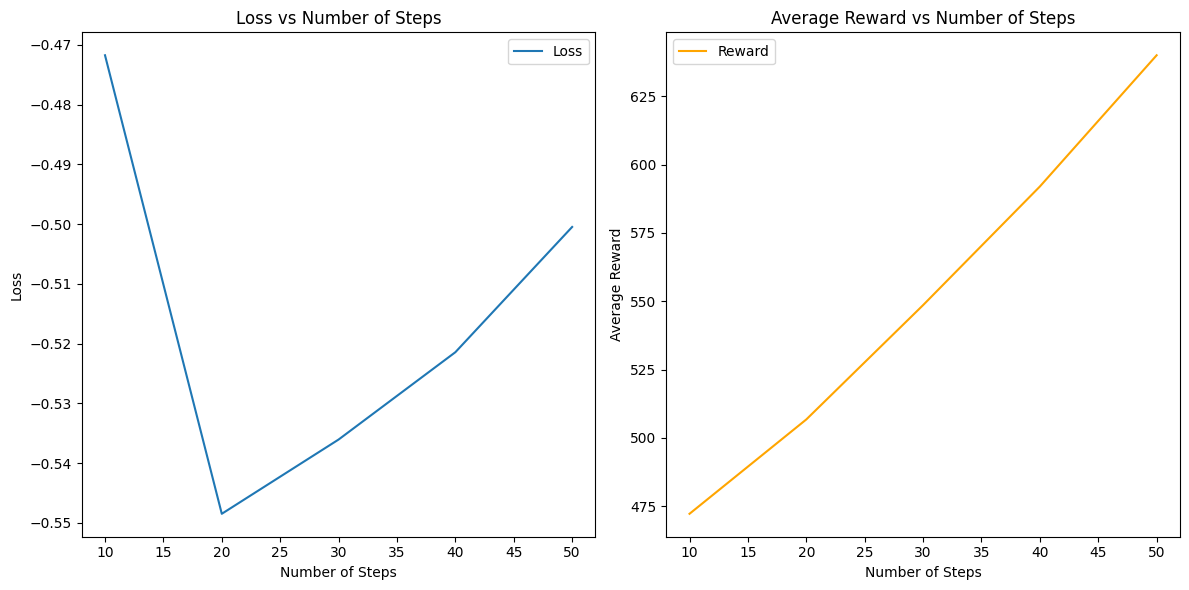

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Loss vs Number of Steps
plt.subplot(1, 2, 1)
plt.plot(steps, losses, label='Loss')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.title('Loss vs Number of Steps')
plt.legend()

# Plotting Reward vs Number of Steps
plt.subplot(1, 2, 2)
plt.plot(steps, rewards, label='Reward', color='orange')
plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Number of Steps')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
envs = ['ant_uni', 'hopper_uni', 'halfcheetah_uni', 'walker2d_uni', 'humanoid_uni']
batch_sizes = [16, 32, 64, 128, 256, 512]
results = {}

@dataclass
class Config:
    batch_size: int
    learning_rate: float
    discount_rate: float
    temperature: float
    clip_param: float
    max_norm_clip: float


for env_name in envs:
    results[env_name] = {}
    
    for batch_size in batch_sizes:
        env = get_env(env_name)
        print(f"Training {env_name} with batch size: {batch_size}")
        
        # Update config with the current batch size
        config = Config(
            batch_size=batch_size,
            learning_rate=3e-4,
            discount_rate=0.99,
            temperature=0.,
            clip_param=0.2,
            max_norm_clip=0.,
        )
        policy_hidden_layers_size = [128, 128]
        policy = MLP(hidden_layers_size=policy_hidden_layers_size, action_size=env.action_size, activation=nn.tanh)
        
        agent = Reinforce(config, policy, env)
        random_key = jax.random.PRNGKey(0)  # Reset random key for each run
        train_state = agent.init(random_key)
        
        num_steps = 1000
        log_period = 10
        
        losses = []
        rewards = []
        steps = []
        
        start_time = time.time()
        for i in range(num_steps // log_period):
            random_key, random_subkey = jax.random.split(random_key)
            (train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)
            
            end_time = time.time()
            steps.append(log_period * (i + 1))
            losses.append(float(jnp.mean(metrics['loss'])))
            rewards.append(float(jnp.mean(jnp.sum(metrics['reward'], axis=-1))))
            
            print(f"Step: {log_period * (i + 1)}")
            print(f"Elapsed Time: {end_time - start_time}")
            print(f"Average Loss: {float(jnp.mean(metrics['loss']))}")
            print(f"Average Reward: {float(jnp.mean(jnp.sum(metrics['reward'], axis=-1)))}")
            print("-" * 50)  # Separator for readability
            start_time = end_time
        
        # Store the results for the current batch size
        results[env_name][batch_size] = {
            'steps': steps,
            'losses': losses,
            'rewards': rewards
        }

    # Plot the results for rewards
    plt.figure()
    for batch_size in batch_sizes:
        plt.plot(results[env_name][batch_size]['steps'], results[env_name][batch_size]['rewards'], label=f'Batch size {batch_size}')
    plt.xlabel('Steps')
    plt.ylabel('Rewards')
    plt.title(f'Rewards vs Steps for {env_name}')
    plt.legend()
    env_dir = os.path.join('REIN_plots', env_name)
    os.makedirs(env_dir, exist_ok=True)
    plt.savefig(os.path.join(env_dir, 'rewards.png'))
    plt.close()

    # Plot the results for losses
    plt.figure()
    for batch_size in batch_sizes:
        plt.plot(results[env_name][batch_size]['steps'], results[env_name][batch_size]['losses'], label=f'Batch size {batch_size}')
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.title(f'Losses vs Steps for {env_name}')
    plt.legend()
    plt.savefig(os.path.join(env_dir, 'losses.png'))
    plt.close()

# Optionally, save the results dictionary to a file for later analysis
with open('REIN_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Training ant_uni with batch size: 16
Step: 10
Elapsed Time: 7.259456634521484
Average Loss: -0.3156987130641937
Average Reward: 448.025146484375
--------------------------------------------------
Step: 20
Elapsed Time: 3.6023905277252197
Average Loss: -0.31389907002449036
Average Reward: 446.6835021972656
--------------------------------------------------
Step: 30
Elapsed Time: 3.6018757820129395
Average Loss: -0.32347041368484497
Average Reward: 452.0729064941406
--------------------------------------------------
Step: 40
Elapsed Time: 3.5991740226745605
Average Loss: -0.15030640363693237
Average Reward: 455.4880065917969
--------------------------------------------------
Step: 50
Elapsed Time: 3.5998644828796387
Average Loss: 0.28629979491233826
Average Reward: 463.6158752441406
--------------------------------------------------
Step: 60
Elapsed Time: 3.5991058349609375
Average Loss: 0.34429165720939636
Average Reward: 467.3988342285156
-----------------------------------------------

In [31]:
envs = ['ant_uni', 'hopper_uni', 'halfcheetah_uni', 'walker2d_uni', 'humanoid_uni']
batch_sizes = [16, 32, 64, 128, 256, 512]
results = {}

@dataclass
class Config:
    batch_size: int
    learning_rate: float
    discount_rate: float
    temperature: float
    clip_param: float
    max_norm_clip: float


for env_name in envs:
    results[env_name] = {}
    
    for batch_size in batch_sizes:
        env = get_env(env_name)
        print(f"Training {env_name} with batch size: {batch_size}")
        
        # Update config with the current batch size
        config = Config(
            batch_size=batch_size,
            learning_rate=1e-3,
            discount_rate=0.99,
            temperature=0.,
            clip_param=0.2,
            max_norm_clip=0.,
        )
        policy_hidden_layers_size = [128, 128]
        policy = MLP(hidden_layers_size=policy_hidden_layers_size, action_size=env.action_size, activation=nn.tanh)
        
        agent = Reinforce(config, policy, env)
        random_key = jax.random.PRNGKey(0)  # Reset random key for each run
        train_state = agent.init(random_key)
        
        num_steps = 1000
        log_period = 10
        
        losses = []
        rewards = []
        steps = []
        
        start_time = time.time()
        for i in range(num_steps // log_period):
            random_key, random_subkey = jax.random.split(random_key)
            (train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)
            
            end_time = time.time()
            steps.append(log_period * (i + 1))
            losses.append(float(jnp.mean(metrics['loss'])))
            rewards.append(float(jnp.mean(jnp.sum(metrics['reward'], axis=-1))))
            
            print(f"Step: {log_period * (i + 1)}")
            print(f"Elapsed Time: {end_time - start_time}")
            print(f"Average Loss: {float(jnp.mean(metrics['loss']))}")
            print(f"Average Reward: {float(jnp.mean(jnp.sum(metrics['reward'], axis=-1)))}")
            print("-" * 50)  # Separator for readability
            start_time = end_time
        
        # Store the results for the current batch size
        results[env_name][batch_size] = {
            'steps': steps,
            'losses': losses,
            'rewards': rewards
        }

    # Plot the results for rewards
    plt.figure()
    for batch_size in batch_sizes:
        plt.plot(results[env_name][batch_size]['steps'], results[env_name][batch_size]['rewards'], label=f'Batch size {batch_size}')
    plt.xlabel('Steps')
    plt.ylabel('Rewards')
    plt.title(f'Rewards vs Steps for {env_name}')
    plt.legend()
    env_dir = os.path.join('REIN_plots', env_name)
    os.makedirs(env_dir, exist_ok=True)
    plt.savefig(os.path.join(env_dir, 'rewards_lr=0.001.png'))
    plt.close()

    # Plot the results for losses
    plt.figure()
    for batch_size in batch_sizes:
        plt.plot(results[env_name][batch_size]['steps'], results[env_name][batch_size]['losses'], label=f'Batch size {batch_size}')
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.title(f'Losses vs Steps for {env_name}')
    plt.legend()
    plt.savefig(os.path.join(env_dir, 'losses_lr=0.001.png'))
    plt.close()

# Optionally, save the results dictionary to a file for later analysis
with open('REIN_results_lr=0.001.pkl', 'wb') as f:
    pickle.dump(results, f)

Training ant_uni with batch size: 16
Step: 10
Elapsed Time: 7.31755256652832
Average Loss: -0.3573698401451111
Average Reward: 445.90380859375
--------------------------------------------------
Step: 20
Elapsed Time: 3.619152784347534
Average Loss: -0.32432135939598083
Average Reward: 444.201171875
--------------------------------------------------
Step: 30
Elapsed Time: 3.6170825958251953
Average Loss: 2.8042237758636475
Average Reward: 447.4421081542969
--------------------------------------------------
Step: 40
Elapsed Time: 3.6183578968048096
Average Loss: 2.6099631786346436
Average Reward: 462.14697265625
--------------------------------------------------
Step: 50
Elapsed Time: 3.617100477218628
Average Loss: 2.475954055786133
Average Reward: 470.1605529785156
--------------------------------------------------
Step: 60
Elapsed Time: 3.617990016937256
Average Loss: 3.2579383850097656
Average Reward: 498.9658203125
--------------------------------------------------
Step: 70
Elapsed 

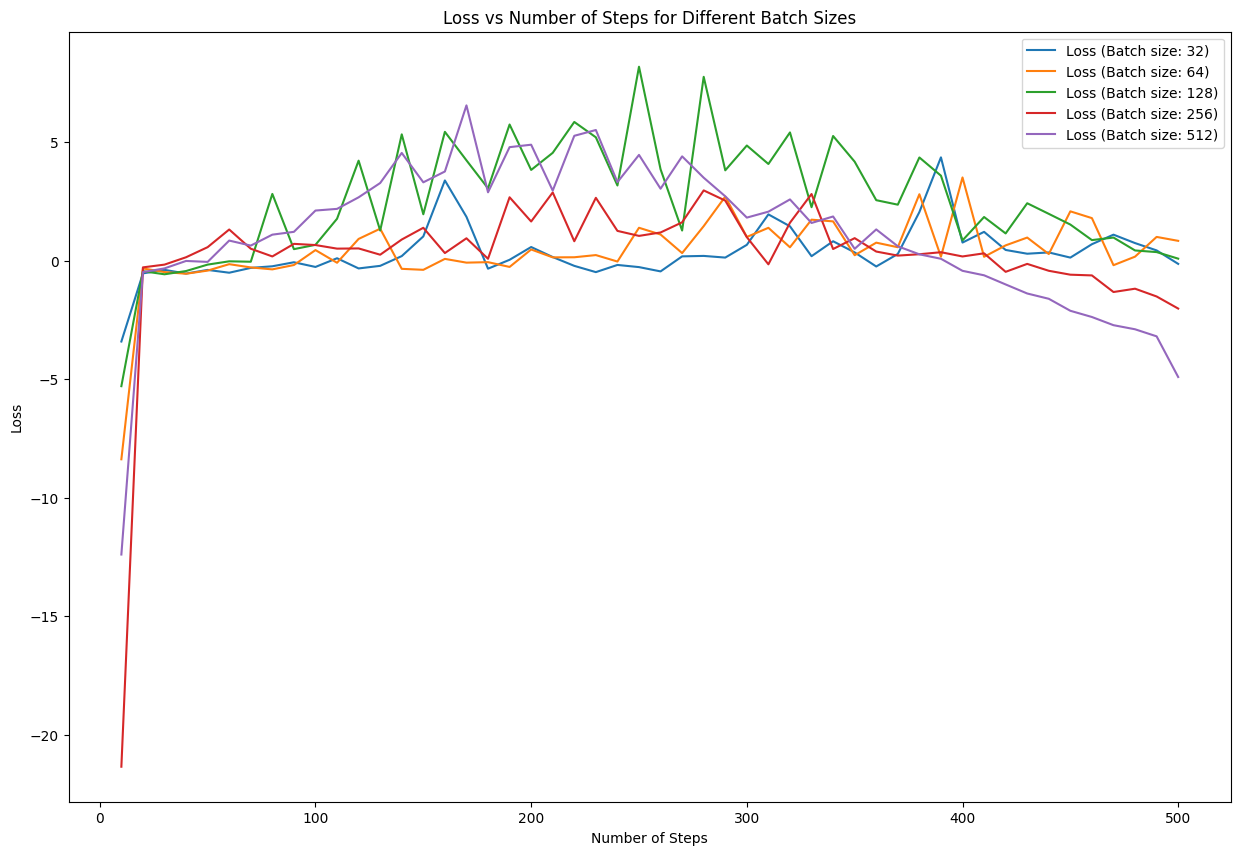

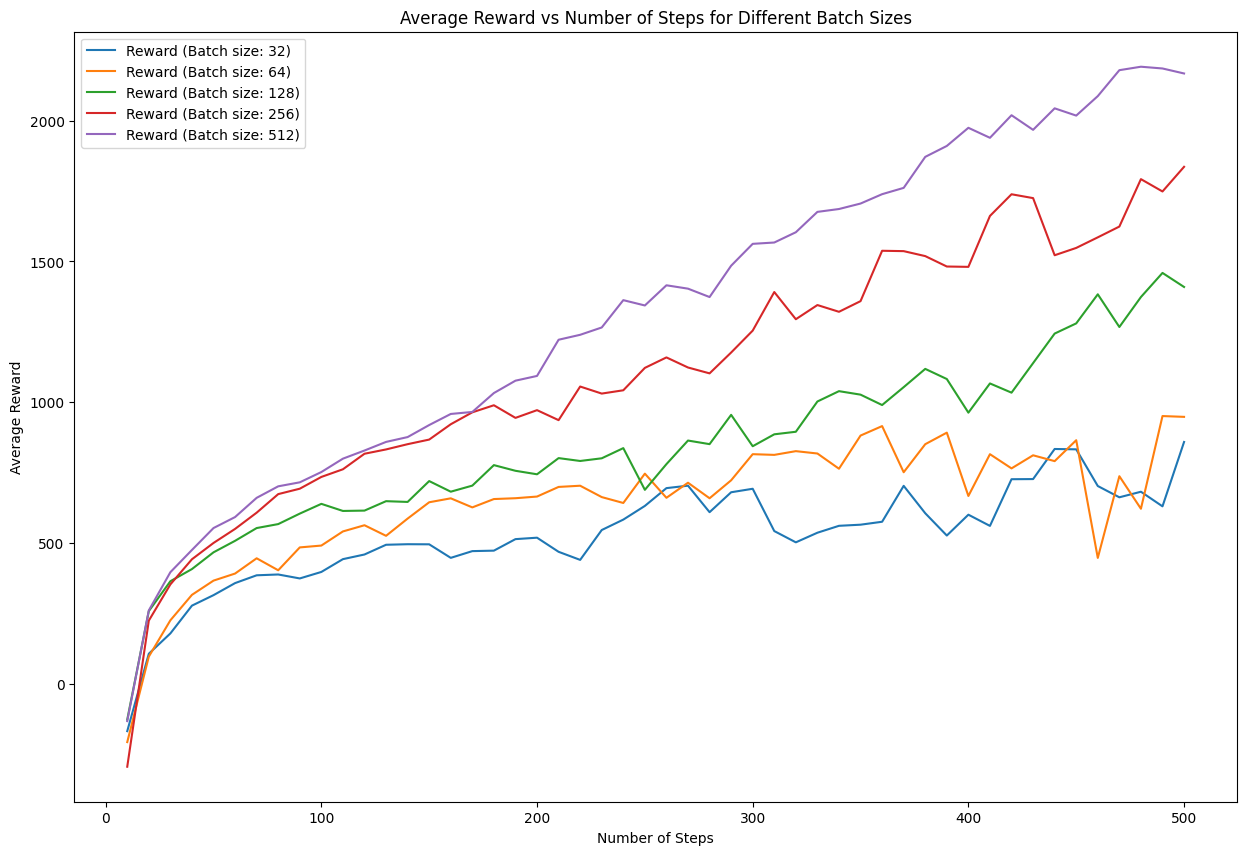

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting the results
plt.figure(figsize=(15, 10))

for batch_size in batch_sizes:
    plt.plot(results[batch_size]['steps'], results[batch_size]['losses'], label=f'Loss (Batch size: {batch_size})')

plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.title('Loss vs Number of Steps for Different Batch Sizes')
plt.legend()
plt.savefig('/vol/bitbucket/km2120/QD-DRL/me-with-sample-based-drl/notebooks/loss_vs_steps.pdf')  # Save the plot as a PDF file
plt.show()

plt.figure(figsize=(15, 10))

for batch_size in batch_sizes:
    plt.plot(results[batch_size]['steps'], results[batch_size]['rewards'], label=f'Reward (Batch size: {batch_size})')

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Number of Steps for Different Batch Sizes')
plt.legend()
plt.savefig('/vol/bitbucket/km2120/QD-DRL/me-with-sample-based-drl/notebooks/reward_vs_steps.pdf')  # Save the plot as an PDF file
plt.show()


In [24]:
batch_sizes = [32, 64, 128, 256, 512]
results = {}

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Update config with the current batch size
    config = Config(
        batch_size=batch_size,
        learning_rate=1e-3,
        discount_rate=0.99,
        temperature=0.,
        clip_param=0.2,
        max_norm_clip=0.,
    )
    
    agent = Reinforce(config, policy, env)
    train_state = agent.init(random_key)
    
    num_steps = 500
    log_period = 10
    
    losses = []
    rewards = []
    steps = []
    
    start_time = time.time()
    for i in range(num_steps // log_period):
        random_key, random_subkey = jax.random.split(random_key)
        (train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)
        
        end_time = time.time()
        steps.append(log_period * (i + 1))
        losses.append(jnp.mean(metrics['loss']))
        rewards.append(jnp.mean(jnp.sum(metrics['reward'], axis=-1)))
        
        print(f"Step: {log_period * (i + 1)}")
        print(f"Elapsed Time: {end_time - start_time}")
        print(f"Average Loss: {jnp.mean(metrics['loss'])}")
        print(f"Average Reward: {jnp.mean(jnp.sum(metrics['reward'], axis=-1))}")
        print("-" * 50)  # Separator for readability
        start_time = end_time
    
    # Store the results for the current batch size
    results[batch_size] = {
        'steps': steps,
        'losses': losses,
        'rewards': rewards
    }


Training with batch size: 32
Step: 10
Elapsed Time: 11.419235467910767
Average Loss: -0.5347203612327576
Average Reward: 466.53759765625
--------------------------------------------------
Step: 20
Elapsed Time: 5.6193132400512695
Average Loss: -0.5326080322265625
Average Reward: 501.17706298828125
--------------------------------------------------
Step: 30
Elapsed Time: 5.622182846069336
Average Loss: -0.5120541453361511
Average Reward: 523.9209594726562
--------------------------------------------------
Step: 40
Elapsed Time: 5.623496055603027
Average Loss: -0.4735192358493805
Average Reward: 547.0232543945312
--------------------------------------------------
Step: 50
Elapsed Time: 5.595346212387085
Average Loss: -0.12713289260864258
Average Reward: 587.69580078125
--------------------------------------------------
Step: 60
Elapsed Time: 5.610146760940552
Average Loss: 0.21489696204662323
Average Reward: 619.5812377929688
--------------------------------------------------
Step: 70
El

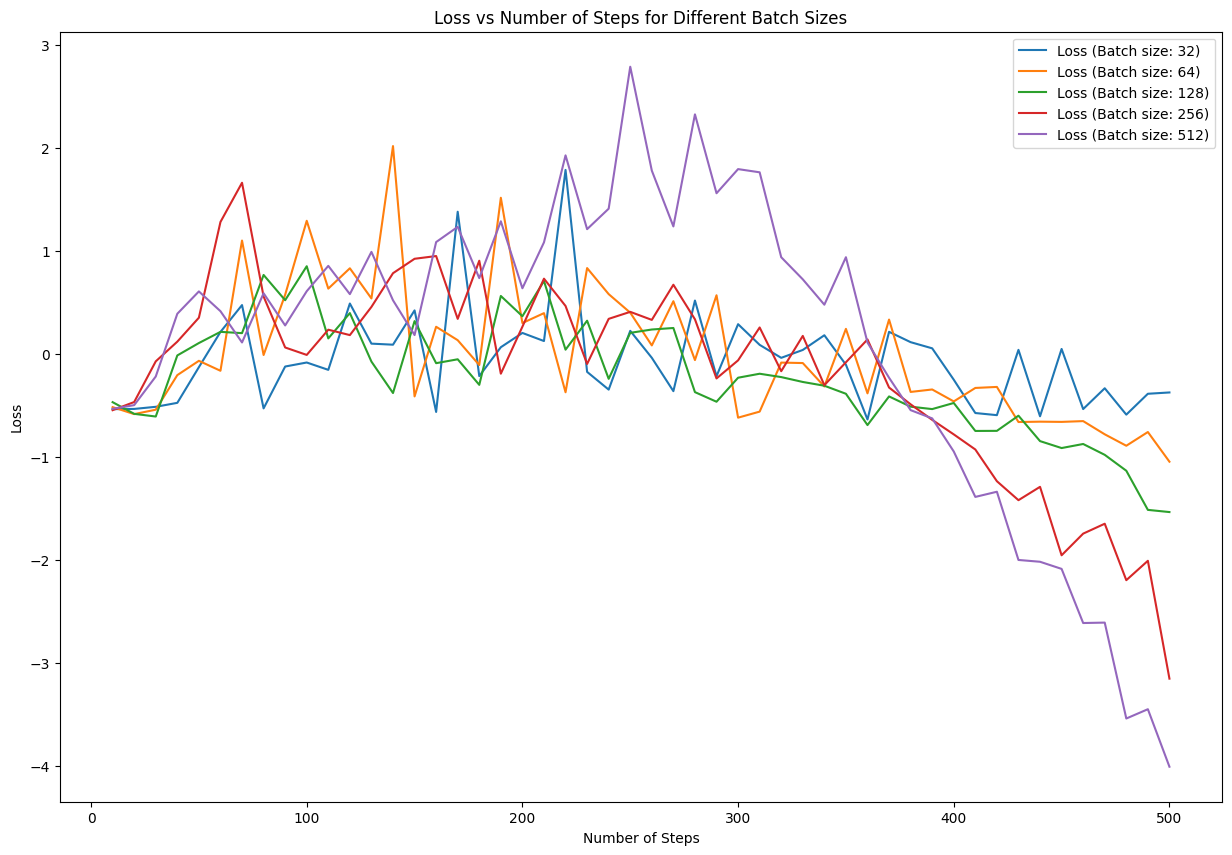

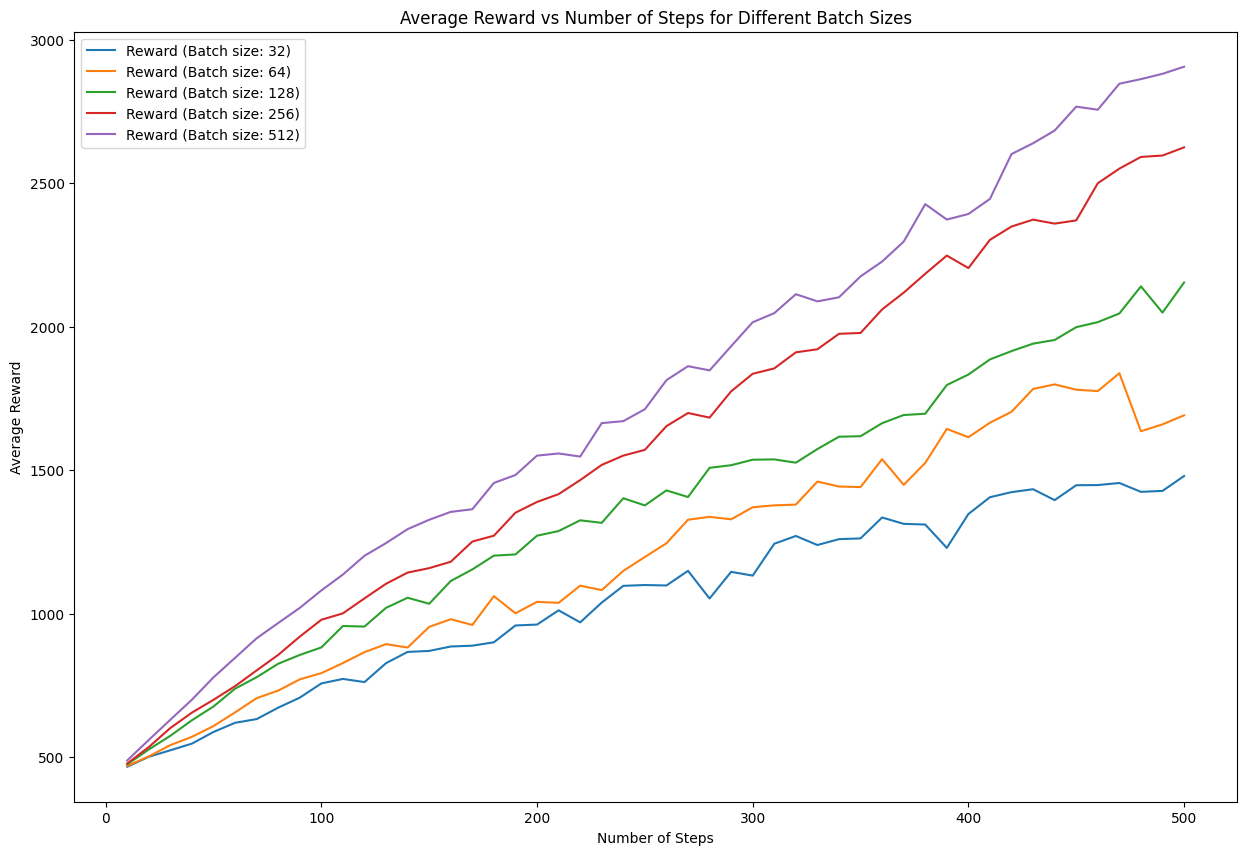

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting the results
plt.figure(figsize=(15, 10))

for batch_size in batch_sizes:
    plt.plot(results[batch_size]['steps'], results[batch_size]['losses'], label=f'Loss (Batch size: {batch_size})')

plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.title('Loss vs Number of Steps for Different Batch Sizes')
plt.legend()
plt.savefig('/vol/bitbucket/km2120/QD-DRL/me-with-sample-based-drl/notebooks/loss_vs_steps.pdf')  # Save the plot as a PDF file
plt.show()

plt.figure(figsize=(15, 10))

for batch_size in batch_sizes:
    plt.plot(results[batch_size]['steps'], results[batch_size]['rewards'], label=f'Reward (Batch size: {batch_size})')

plt.xlabel('Number of Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Number of Steps for Different Batch Sizes')
plt.legend()
plt.savefig('/vol/bitbucket/km2120/QD-DRL/me-with-sample-based-drl/notebooks/reward_vs_steps.pdf')  # Save the plot as an PDF file
plt.show()


In [9]:
rollout = []
rewards = []

random_key, random_subkey = jax.random.split(random_key)
env_state = jax.jit(env.reset)(random_subkey)
done = False
while not done:
	rollout.append(env_state)

	random_key, random_subkey = jax.random.split(random_key)
	next_env_state, action, action_logp = agent.sample_step(random_subkey, train_state, env_state)

	rewards.append(next_env_state.reward)
	done = next_env_state.done
	env_state = next_env_state

print(len(rollout), sum(rewards))

a = html.render(env.sys, [s.qp for s in rollout])
HTML(a)

1000 3462.3916
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
F

AttributeError: 'QP' object has no attribute 'x'

In [ ]:
with open("/project/rollout.html", "w") as f:
	f.write(a)

# Descriptor-Conditioned Policy

## Agent

In [4]:
_half_log2pi = 0.5 * jnp.log(2 * jnp.pi)
EPS = 1e-8

class MLPDC(nn.Module):
	"""Descriptor-conditioned MLP module."""
	hidden_layers_size: Tuple[int, ...]
	action_size: int
	activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh

	def setup(self):
		if env_name == "walker2d_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size)
			self.log_std = self.param("log_std", lambda _, shape: -0.5*jnp.ones(shape), (self.action_size,))
		elif env_name == "ant_uni" or env_name == "ant_omni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2))) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01))
			self.log_std = self.param("log_std", lambda _, shape: -1.*jnp.ones(shape), (self.action_size,))
		elif env_name == "humanoid_uni":
			self.hidden_layers = [nn.Dense(hidden_layer_size, kernel_init=jax.nn.initializers.orthogonal(scale=jnp.sqrt(2))) for hidden_layer_size in self.hidden_layers_size]
			self.mean = nn.Dense(self.action_size, kernel_init=jax.nn.initializers.orthogonal(scale=0.01))
			self.log_std = self.param("log_std", lambda _, shape: jnp.zeros(shape), (self.action_size,))
		else:
			ValueError(f"Environment {env_name} not supported.")

	def distribution_params(self, obs: jnp.ndarray, desc: jnp.ndarray):
		hidden = jnp.concatenate([obs, desc], axis=-1)
		for hidden_layer in self.hidden_layers:
			hidden = self.activation(hidden_layer(hidden))

		mean = self.mean(hidden)
		log_std = self.log_std
		std = jnp.exp(log_std)

		return mean, log_std, std

	def logp(self, obs: jnp.ndarray, desc: jnp.ndarray, action: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		mean, log_std, std = self.distribution_params(obs, desc)

		# Log probability
		logp = jnp.sum(-0.5 * jnp.square((action - mean)/(std + EPS)) - _half_log2pi - log_std, axis=-1)

		return logp

	def entropy(self, obs: jnp.ndarray, desc: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		_, _, std = self.distribution_params(obs, desc)

		entropy = self.action_size * (0.5 + _half_log2pi) + 0.5 * jnp.log(jnp.prod(std))
		return entropy

	def __call__(self, random_key, obs: jnp.ndarray, desc: jnp.ndarray) -> jnp.ndarray:
		# Distribution parameters
		mean, log_std, std = self.distribution_params(obs, desc)

		# Sample action
		rnd = jax.random.normal(random_key, shape=(self.action_size,))
		action = jax.lax.stop_gradient(mean + rnd * std)

		# Log probability
		logp = jnp.sum(-0.5 * jnp.square(rnd) - _half_log2pi - log_std, axis=-1)

		return action, logp

# Initialize policy
policy_hidden_layers_size = [256, 256]
policy = MLPDC(hidden_layers_size=policy_hidden_layers_size, action_size=env.action_size, activation=nn.tanh)

## REINFORCE

In [5]:
@dataclass
class ConfigDC:
	num_desc: int = 16
	num_her: int = 10
	batch_size: int = 512
	learning_rate: float = 1e-3
	discount_rate: float = 0.999
	desc_reward_weight: float = 0.5 * jnp.sqrt(2) * 250
	temperature: float = 0.
	clip_param: float = 0.2
	max_norm_clip: float = 0.


class ReinforceDC:

	def __init__(self, config, policy, env):
		self._config = config
		self._policy = policy
		self._env = env

		if env.state_descriptor_name == "feet_contact":
			self.get_desc = self.get_feet_contact_rate
		elif env.state_descriptor_name == "xy_position":
			self.get_desc = self.get_final_xy_position
		else:
			ValueError(f"Descriptor {env.state_descriptor_name} not supported.")

	def init(self, random_key):
		# Initialize params
		random_key_1, random_key_2 = jax.random.split(random_key)
		fake_obs = jnp.zeros(shape=(env.observation_size,))
		fake_desc = jnp.zeros(shape=(env.behavior_descriptor_length,))
		params = self._policy.init(random_key_1, random_key_2, fake_obs, fake_desc)

		# Initialize optimizer
		tx = optax.adam(self._config.learning_rate)

		# Return train state
		return TrainState.create(apply_fn=policy.apply, params=params, tx=tx)

	@partial(jax.jit, static_argnames=("self",))
	def logp_fn(self, params, obs, desc, action):
		return self._policy.apply(params, obs, desc, action, method=self._policy.logp)

	@partial(jax.jit, static_argnames=("self",))
	def entropy_fn(self, params, obs, desc):
		return self._policy.apply(params, obs, desc, method=self._policy.entropy)

	@partial(jax.jit, static_argnames=("self",))
	def sample_step(self, random_key, train_state, env_state, desc):
		action, action_logp = train_state.apply_fn(train_state.params, random_key, env_state.obs, desc)
		next_env_state = self._env.step(env_state, action)

		return next_env_state, action, action_logp

	@partial(jax.jit, static_argnames=("self",))
	def sample_trajectory(self, random_key, train_state, desc):
		random_keys = jax.random.split(random_key, self._env.episode_length+1)
		env_state_init = self._env.reset(random_keys[-1])

		def _scan_sample_step(carry, x):
			(train_state, env_state, desc) = carry
			(random_key,) = x

			next_env_state, action, action_logp = self.sample_step(random_key, train_state, env_state, desc)
			return (train_state, next_env_state, desc), (env_state.obs, action, action_logp, next_env_state.reward, env_state.done, env_state.info["state_descriptor"])

		_, (obs, action, action_logp, reward, done, state_desc) = jax.lax.scan(
			_scan_sample_step,
			(train_state, env_state_init, desc),
			(random_keys[:self._env.episode_length],),
			length=self._env.episode_length,
		)

		mask = 1. - jnp.clip(jnp.cumsum(done), a_min=0., a_max=1.)

		return obs, action, action_logp, reward, state_desc, mask

	@partial(jax.jit, static_argnames=("self",))
	def sample_trajectories(self, random_key, train_state, desc):
		random_keys = jax.random.split(random_key, self._config.batch_size)
		obs, action, logp, reward, state_desc, mask = jax.vmap(self.sample_trajectory, in_axes=(0, None, None))(random_keys, train_state, desc)
		return obs, action, logp, reward, state_desc, mask

	@partial(jax.jit, static_argnames=("self",))
	def get_done_index(self, mask):
		mask = jnp.expand_dims(mask, axis=-1)
		done_index = jnp.int32(jnp.sum(mask)) - 1
		return done_index

	@partial(jax.jit, static_argnames=("self",))
	def get_final_xy_position(self, state_desc, mask):
		done_index = self.get_done_index(mask)
		return state_desc[done_index]

	@partial(jax.jit, static_argnames=("self",))
	def get_feet_contact_rate(self, state_desc, mask):
		mask = jnp.expand_dims(mask, axis=-1)
		return jnp.sum(state_desc * mask, axis=0)/jnp.sum(mask)

	@partial(jax.jit, static_argnames=("self",))
	def get_desc_current(self, state_desc):
		masks = jnp.tril(jnp.ones((agent._env.episode_length, agent._env.episode_length)))
		desc_current = jax.vmap(self.get_desc, in_axes=(None, 0))(state_desc, masks)

		return desc_current

	@partial(jax.jit, static_argnames=("self",))
	def get_desc_reward_(self, state_desc, desc, mask):
		return jnp.zeros(mask.shape)

	@partial(jax.jit, static_argnames=("self",))
	def get_desc_reward_(self, state_desc, desc, mask):
		desc_current = self.get_desc_current(state_desc)
		desc_next = jnp.roll(desc_current, -1, axis=0)

		desc_reward = jnp.linalg.norm(desc_current - desc, axis=-1) - jnp.linalg.norm(desc_next - desc, axis=-1)
		desc_reward = desc_reward.at[-1].set(0.)
		return self._config.desc_reward_weight * desc_reward

	@partial(jax.jit, static_argnames=("self",))
	def get_desc_reward_(self, state_desc, desc, mask):
		done_index = self.get_done_index(mask)
		desc_observed = self.get_desc(state_desc, mask)

		desc_reward = jnp.zeros(mask.shape)
		return desc_reward.at[done_index].set(jnp.clip(-self._config.desc_reward_weight * jnp.linalg.norm(desc - desc_observed), a_min=-10., a_max=0.))

	@partial(jax.jit, static_argnames=("self",))
	def get_desc_reward(self, state_desc, desc, mask):
		done_index = self.get_done_index(mask)
		desc_observed = self.get_desc(state_desc, mask)

		desc_reward = jnp.zeros(mask.shape)
		return desc_reward.at[done_index].set(-self._config.desc_reward_weight * jnp.linalg.norm(desc - desc_observed))

	@partial(jax.jit, static_argnames=("self",))
	def get_return(self, reward):

		def _body(carry, x):
			(next_return,) = carry
			(reward,) = x

			current_return = reward + self._config.discount_rate * next_return
			return (current_return,), (current_return,)

		_, (return_,) = jax.lax.scan(
			_body,
			(jnp.array(0.),),
			(reward,),
			length=self._env.episode_length,
			reverse=True,)

		return return_

	@partial(jax.jit, static_argnames=("self",))
	def standardize(self, return_):
		return jax.nn.standardize(return_, axis=0, variance=1., epsilon=EPS)

	@partial(jax.jit, static_argnames=("self",))
	def get_return_standardized(self, reward, state_desc, desc, mask):
		# Compute descriptor reward
		desc_reward = jax.vmap(self.get_desc_reward)(state_desc, desc, mask)
		reward = (reward + desc_reward) * mask

		return_ = jax.vmap(self.get_return)(reward)
		return self.standardize(return_)

	@partial(jax.jit, static_argnames=("self",))
	def clip_by_l2_norm(self, x: jnp.ndarray, max_norm: float) -> jnp.ndarray:
		"""Clip gradients to maximum l2 norm `max_norm`."""
		sum_sq = jnp.sum(jnp.vdot(x, x))
		nonzero = sum_sq > 0

		sum_sq_ones = jnp.where(nonzero, sum_sq, jnp.ones_like(sum_sq))
		norm = jnp.where(nonzero, jnp.sqrt(sum_sq_ones), sum_sq)

		return (x * max_norm) / jnp.maximum(norm, max_norm)

	@partial(jax.jit, static_argnames=("self",))
	def loss_reinforce(self, params, obs, desc, action, logp, mask, return_standardized):
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(desc), jax.lax.stop_gradient(action))
		return -jnp.mean(jnp.multiply(logp_ * mask, jax.lax.stop_gradient(return_standardized)))

	@partial(jax.jit, static_argnames=("self",))
	def loss_reinforce_with_is(self, params, obs, desc, action, logp, mask, return_standardized):
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(desc), jax.lax.stop_gradient(action))
		ratio = jnp.exp(logp_ - jax.lax.stop_gradient(logp))
		return -jnp.mean(jnp.multiply(ratio * mask, jax.lax.stop_gradient(return_standardized)))

	@partial(jax.jit, static_argnames=("self",))
	def loss_ppo(self, params, obs, desc, action, logp, mask, return_standardized):
		logp_ = self.logp_fn(params, jax.lax.stop_gradient(obs), jax.lax.stop_gradient(desc), jax.lax.stop_gradient(action))
		ratio = jnp.exp(logp_ - jax.lax.stop_gradient(logp))

		pg_loss_1 = jnp.multiply(ratio * mask, jax.lax.stop_gradient(return_standardized))
		pg_loss_2 = jax.lax.stop_gradient(return_standardized) * jax.lax.clamp(1. - self._config.clip_param, ratio, 1. + self._config.clip_param)
		return -jnp.mean(jnp.minimum(pg_loss_1, pg_loss_2))

	@partial(jax.jit, static_argnames=("self",))
	def train_step(self, random_key, train_state):
		random_keys = jax.random.split(random_key, self._config.num_desc + 2)

		# Sample descriptors
		desc = jax.random.uniform(random_keys[-1], shape=(self._config.num_desc, self._env.behavior_descriptor_length,), minval=self._env.behavior_descriptor_limits[0], maxval=self._env.behavior_descriptor_limits[1])
		# desc = jnp.array([[5., 0.]])/max_bd
		desc = desc/self._env.behavior_descriptor_limits[1]
		desc_tile = jnp.tile(desc[:, None, None, :], (1, self._config.batch_size, self._env.episode_length, 1))

		# Sample trajectories
		obs, action, logp, reward, state_desc, mask = jax.vmap(self.sample_trajectories, in_axes=(0, None, 0))(random_keys[:self._config.num_desc], train_state, desc)
		desc_observed = jax.vmap(jax.vmap(self.get_desc))(state_desc, mask)/max_bd
		desc_observed_tile = jnp.tile(desc_observed[:, :, None, :], (1, 1, self._env.episode_length, 1))

		# Add entropy term to reward
		reward += self._config.temperature * (-logp)

		# Sample descriptors with HER
		random_keys = jax.random.split(random_keys[-2], self._config.num_desc * self._config.batch_size)
		alpha = jax.vmap(jax.random.permutation, in_axes=(0, None))(random_keys, jnp.linspace(0., 1., num=self._config.num_her))
		alpha = jnp.transpose(alpha).reshape(self._config.num_her, self._config.num_desc, self._config.batch_size)
		alpha = alpha[..., None, None]
		desc_hers = (1 - alpha) * desc_tile + alpha * desc_observed_tile

		# alpha = jnp.linspace(0., 1., num=self._config.num_her)
		# desc_hers = jax.vmap(lambda alpha: (1 - alpha) * desc_tile + alpha * desc_observed_tile)(alpha)

		def train_epoch(_, x):
			(desc_her,) = x

			# Compute standardized return
			return_standardized = jax.vmap(self.get_return_standardized)(reward, state_desc, desc_her[:, :, 0, :], mask)

			# Compute loss and grads
			loss, grads = jax.value_and_grad(self.loss_reinforce_with_is)(train_state.params, obs, desc_her, action, logp, mask, return_standardized)

			return (), (loss, grads,)

		_, (loss, grads,) = jax.lax.scan(
			train_epoch,
			(),
			(desc_hers,),
			length=self._config.num_her,)

		grads = jax.tree_util.tree_map(lambda x: jnp.mean(x, axis=0), grads)
		train_state = train_state.apply_gradients(grads=grads)

		metrics = {
			"loss": loss,
			"reward": reward * mask,
			"mask": mask,
			"desc_error_mean": jnp.mean(jnp.linalg.norm(desc_tile[:, :, 0, :] - desc_observed_tile[:, :, 0, :], axis=-1))
			}

		return (train_state,), (metrics,)

	@partial(jax.jit, static_argnames=("self", "num_steps"))
	def train(self, random_key, train_state, num_steps):
		random_keys = jax.random.split(random_key, num_steps)

		def _scan_train_step(carry, x):
			(train_state,) = carry
			(random_key,) = x

			(train_state,), (metrics,) = self.train_step(random_key, train_state)

			return (train_state,), (metrics,)

		(train_state,), (metrics,) = jax.lax.scan(
			_scan_train_step,
			(train_state,),
			(random_keys,),
			length=num_steps,)

		return (train_state,), (metrics,)

## Evaluation

In [7]:
config = ConfigDC(
	num_desc=32,
    num_her=10,
	batch_size=512,
	learning_rate=1e-3,
	discount_rate=0.999,
    desc_reward_weight=200.,
	temperature=0.,
	clip_param=0.2,
	max_norm_clip=0.,
)

agent = ReinforceDC(config, policy, env)
train_state = agent.init(random_key)

NameError: name 'ConfigDC' is not defined

In [7]:
num_steps = 1000
log_period = 10

start_time = time.time()
for i in range(num_steps // log_period):
	random_key, random_subkey = jax.random.split(random_key)
	(train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)

	end_time = time.time()
	print(i+1, end_time - start_time, jnp.mean(metrics["loss"]), jnp.mean(jnp.sum(metrics["reward"], axis=-1)), jnp.mean(jnp.sum(metrics["mask"], axis=-1)), jnp.mean(metrics["desc_error_mean"]))
	start_time = end_time

1 37.129730224609375 0.00237312 103.37136 249.99986 0.77753425
2 29.151357889175415 0.0016987249 71.58422 250.0 0.7859728
3 29.379750967025757 -0.033738542 88.10036 250.0 0.7474089
4 29.894392728805542 -0.034438446 79.42123 250.0 0.74084586
5 30.376922369003296 -0.051766787 83.03362 250.0 0.76573336
6 31.18331527709961 -0.04782931 83.25191 250.0 0.73493105
7 32.22794318199158 -0.045268893 91.990555 250.0 0.7493954
8 32.757604122161865 -0.044007953 94.284325 250.0 0.7624535
9 34.1392183303833 -0.0490383 98.260124 250.0 0.76538944
10 35.047406911849976 -0.0441718 99.361916 250.0 0.75992197
11 35.43904185295105 -0.054768518 100.48089 250.0 0.7510988
12 36.69450616836548 -0.06954323 102.246254 250.0 0.74933255
13 37.21571731567383 -0.05631034 103.31266 250.0 0.73505896
14 37.76760411262512 -0.07859456 107.08709 250.0 0.72753525
15 38.44966244697571 -0.07124505 111.15645 250.0 0.7472126
16 38.45505118370056 -0.068817236 113.6881 250.0 0.73767686
17 39.225605964660645 -0.08049137 115.3103 25

KeyboardInterrupt: 

In [ ]:
num_steps = 1000
log_period = 10

start_time = time.time()
for i in range(num_steps // log_period):
	random_key, random_subkey = jax.random.split(random_key)
	(train_state,), (metrics,) = agent.train(random_subkey, train_state, log_period)

	end_time = time.time()
	print(i+1, end_time - start_time, jnp.mean(metrics["loss"]), jnp.mean(jnp.sum(metrics["reward"], axis=-1)), jnp.mean(jnp.sum(metrics["mask"], axis=-1)), jnp.mean(metrics["desc_error_mean"]))
	start_time = end_time

1 40.232600688934326 -1.4698431 335.15817 214.95483 0.69722635
2 29.48937439918518 -13.37372 728.11066 647.3524 0.57311463
3 29.78851294517517 -5.0552225 975.17804 922.459 0.69719166
4 30.315058708190918 -3.694589 1051.2346 924.72015 0.60072124
5 31.075769662857056 -2.307785 1111.8434 953.30707 0.6147
6 31.65229344367981 -1.8851348 1131.192 959.25275 0.5919142
7 32.7152681350708 -1.4896713 1147.0433 964.48987 0.58981305
8 33.34413290023804 -1.4408137 1165.5917 965.7641 0.5921249
9 34.086485862731934 -1.4257594 1190.1405 962.3242 0.5782284
10 35.030149698257446 -1.2729025 1219.9788 966.2884 0.55730957
11 35.805384397506714 -1.6552917 1230.8359 960.11847 0.531954
12 36.548659324645996 -1.5328988 1243.4512 963.6921 0.58475274
13 37.24944281578064 -1.7269129 1249.941 959.25336 0.56801873
14 37.725515842437744 -2.0775895 1257.2059 955.04803 0.55120486
15 37.551207542419434 -5.351482 1266.6361 929.0849 0.49174842
16 38.15990209579468 -18.73647 1304.7917 857.3078 0.46916604
17 38.530980825424

KeyboardInterrupt: 

In [18]:
rollout = []
rewards = []

desc = jnp.array([1., 1.])/max_bd

random_key, random_subkey = jax.random.split(random_key)
env_state = jax.jit(env.reset)(random_subkey)
done = False
while not done:
	rollout.append(env_state)
	
	random_key, random_subkey = jax.random.split(random_key)
	next_env_state, action, action_logp = agent.sample_step(random_subkey, train_state, env_state, desc)

	rewards.append(next_env_state.reward)
	done = next_env_state.done
	env_state = next_env_state
	
print(len(rollout), sum(rewards))

a = html.render(env.sys, [s.qp for s in rollout])
HTML(a)

830 4435.6123


In [29]:
with open("/project/rollout.html", "w") as f:
	f.write(a)